In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Generate dummy data

In [2]:
# True parameter values
true_z = 0.69

# Size of dataset
size = 10

# Generate Tosses
x = np.random.binomial(n=1, p=true_z, size=size)

In [3]:
x

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1])

# Prior Constants

In [4]:
alpha, beta = 10, 10

## Analytical Solution

In [6]:
from scipy.stats import beta as beta_dist

# analytical solution for p(z | x)
def posterior_dist(z, x, alpha, beta):
    a = alpha + x.sum()
    b = beta + len(x) - x.sum()

    return beta_dist.pdf(z, a, b)

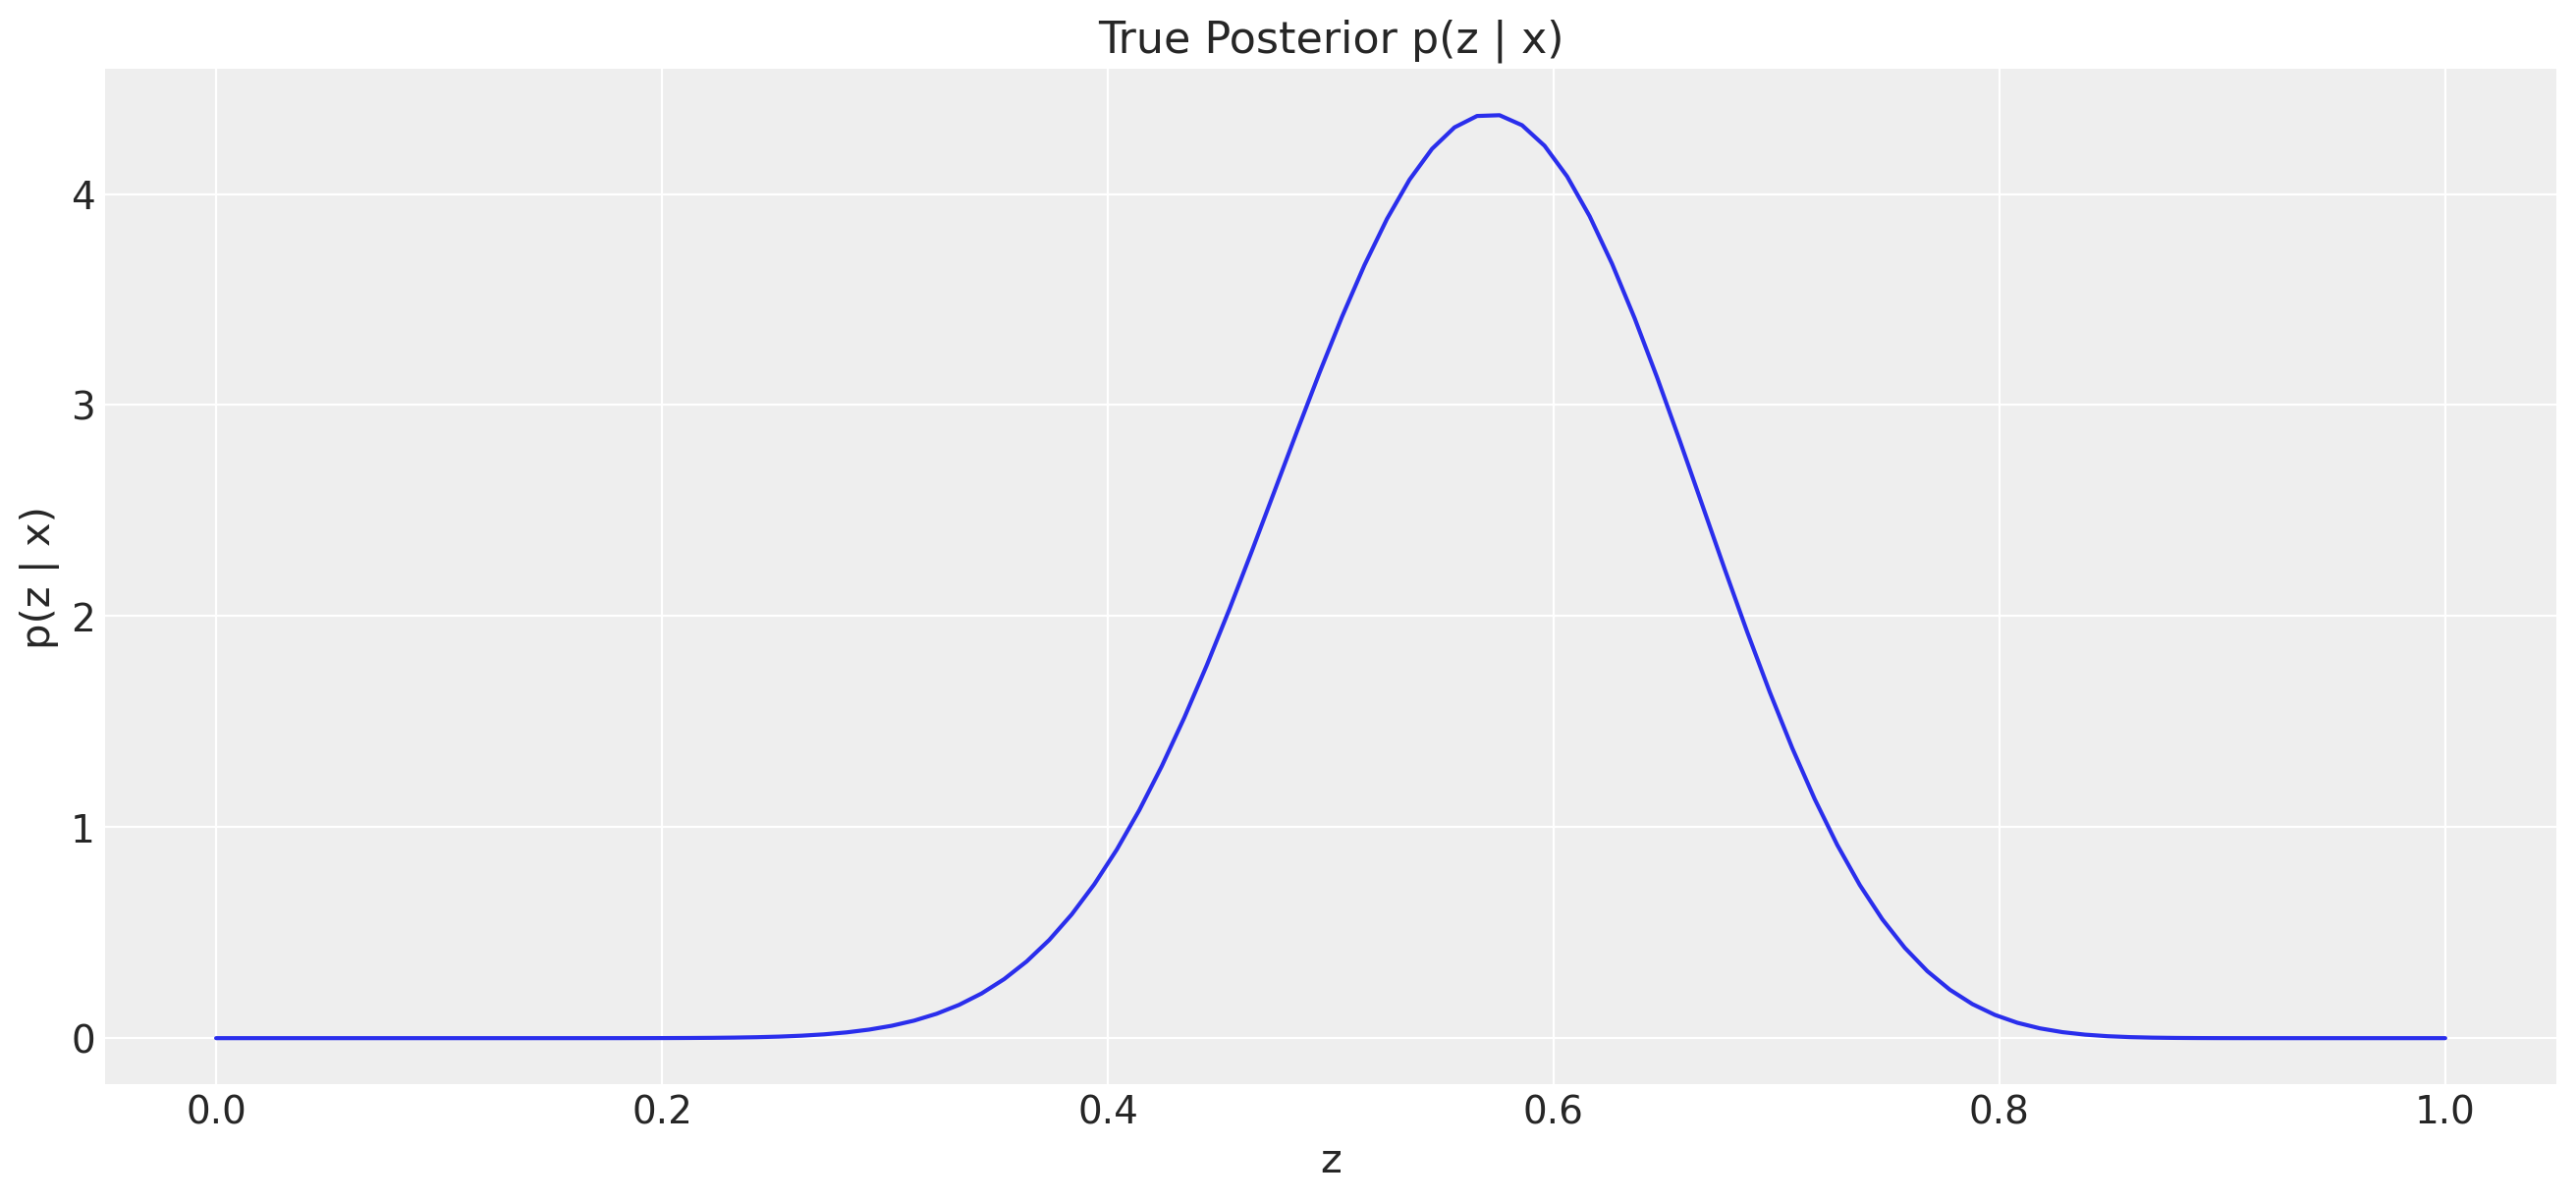

In [8]:
# plot posterior over pi in range [0,1]
z_range = np.linspace(0, 1, 100)
posterior = [posterior_dist(z_i, x, alpha, beta) for z_i in z_range]

plt.figure(figsize=(13,6))
plt.plot(z_range, posterior)
plt.xlabel("z")
plt.ylabel("p(z | x)")
plt.title("True Posterior p(z | x)")
plt.show()

# Define the model using Probabilistic Programming!

In [9]:
import pymc as pm

model = pm.Model()

with model:
    # Prior p(z)
    z = pm.Beta("z", alpha=alpha, beta=beta)

    # Likelihood p(x | z)
    x_likelihood = pm.Bernoulli("x_likelihood", p=z, observed=x)

# Approximate Inference using MCMC

In [10]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


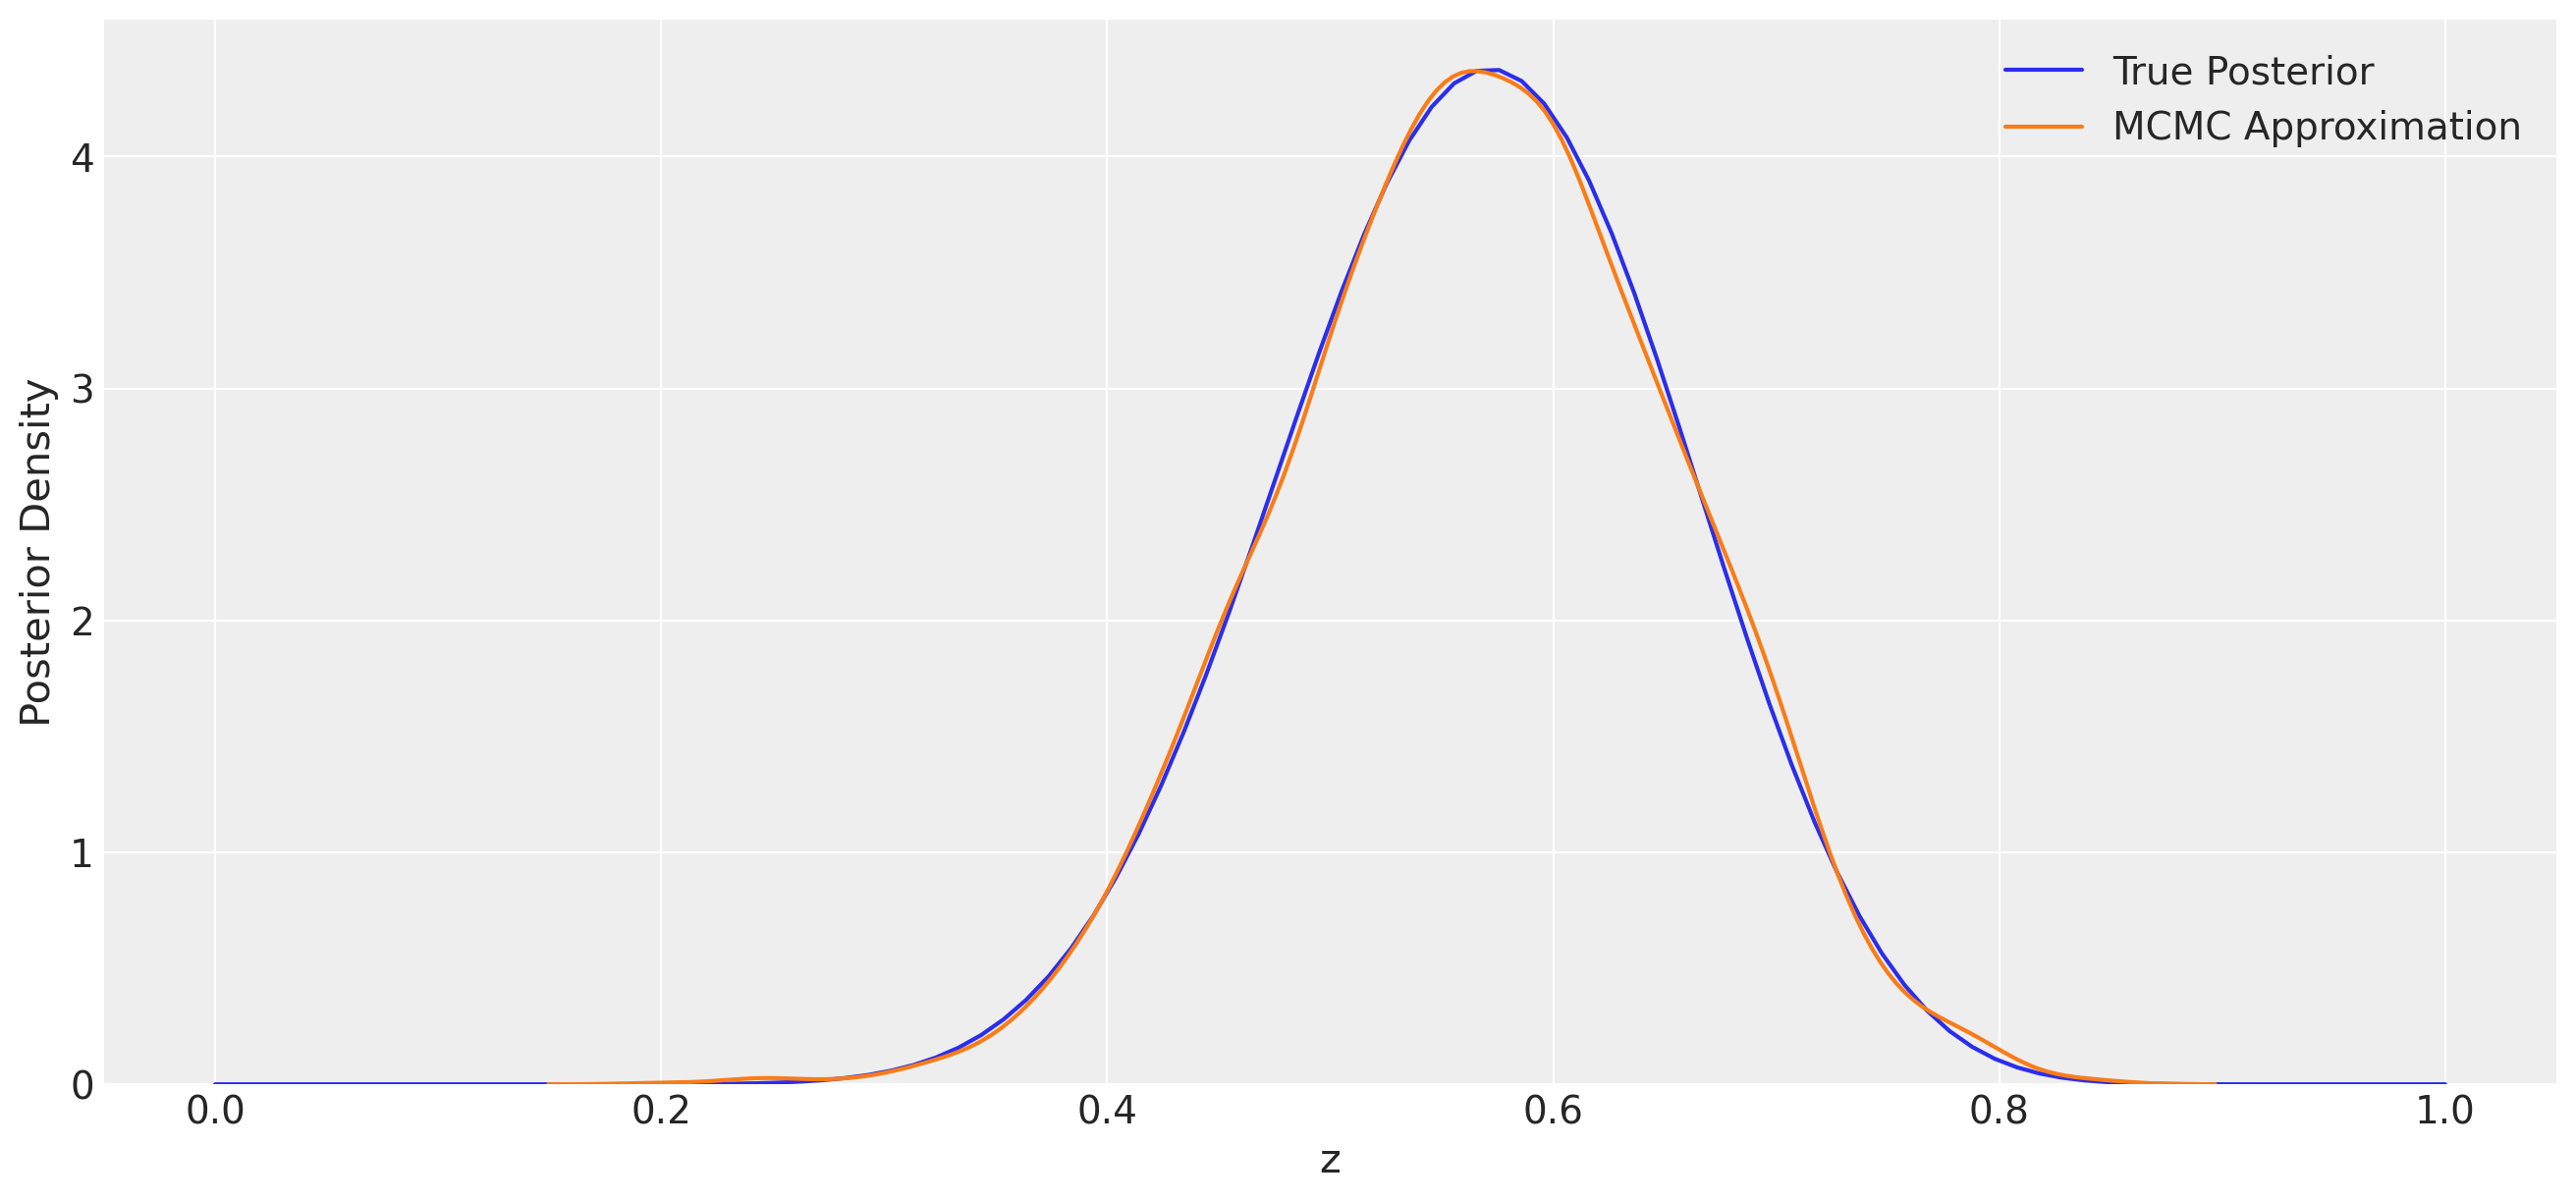

In [15]:
mcmc_posterior = np.array(idata.posterior['z']).flatten()
# change figure size
plt.figure(figsize=(13,6))
sns.lineplot(x=z_range, y=posterior)
sns.kdeplot(mcmc_posterior)
plt.xlabel('z'); plt.ylabel('Posterior Density')
plt.legend(labels=['True Posterior', 'MCMC Approximation'])
plt.show()

# Pyro

In [21]:
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO

from tqdm import tqdm

x = [torch.tensor(x_i, dtype=torch.float32) for x_i in x]
alpha, beta = torch.tensor(alpha), torch.tensor(beta)

/tmp/ipykernel_85614/3851521905.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = [torch.tensor(x_i, dtype=torch.float32) for x_i in x]
/tmp/ipykernel_85614/3851521905.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha, beta = torch.tensor(alpha), torch.tensor(beta)


## Define the model using Pyro

In [22]:
def model(x):
    # Prior p(z)
    z = pyro.sample("z", dist.Beta(alpha, beta))

    # Likelihood p(x | z)
    for i in range(len(x)):
        pyro.sample(f"x_{i}_likelihood", dist.Bernoulli(z), obs=x[i])

Since we perform *variational* inference, we need to specify a **variational distribution** $q_\phi(\mathbf{z})$. 

In this example, we choose $$q_\phi(\mathbf{z}) = \text{Beta}(\mathbf{z}; \alpha_q, \beta_q)$$i.e., $\phi = (\alpha_q, \beta_q)^T$.

In [23]:
def variational_distribution(x):
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0), constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0), constraint=constraints.positive)

    # Define q(z)
    pyro.sample("z", dist.Beta(alpha_q, beta_q))

# Approximate Inference using Variational Inference

In [24]:
optimizer = Adam({"lr": 1e-3})
# Stochastic Variational Inference
svi = SVI(model, variational_distribution, optimizer, loss=Trace_ELBO())

# Use Adam to maximize the ELBO (w.r.t. phi)
for step in tqdm(range(3000)):
    svi.step(x)

100%|██████████| 3000/3000 [00:14<00:00, 204.53it/s]


In [25]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

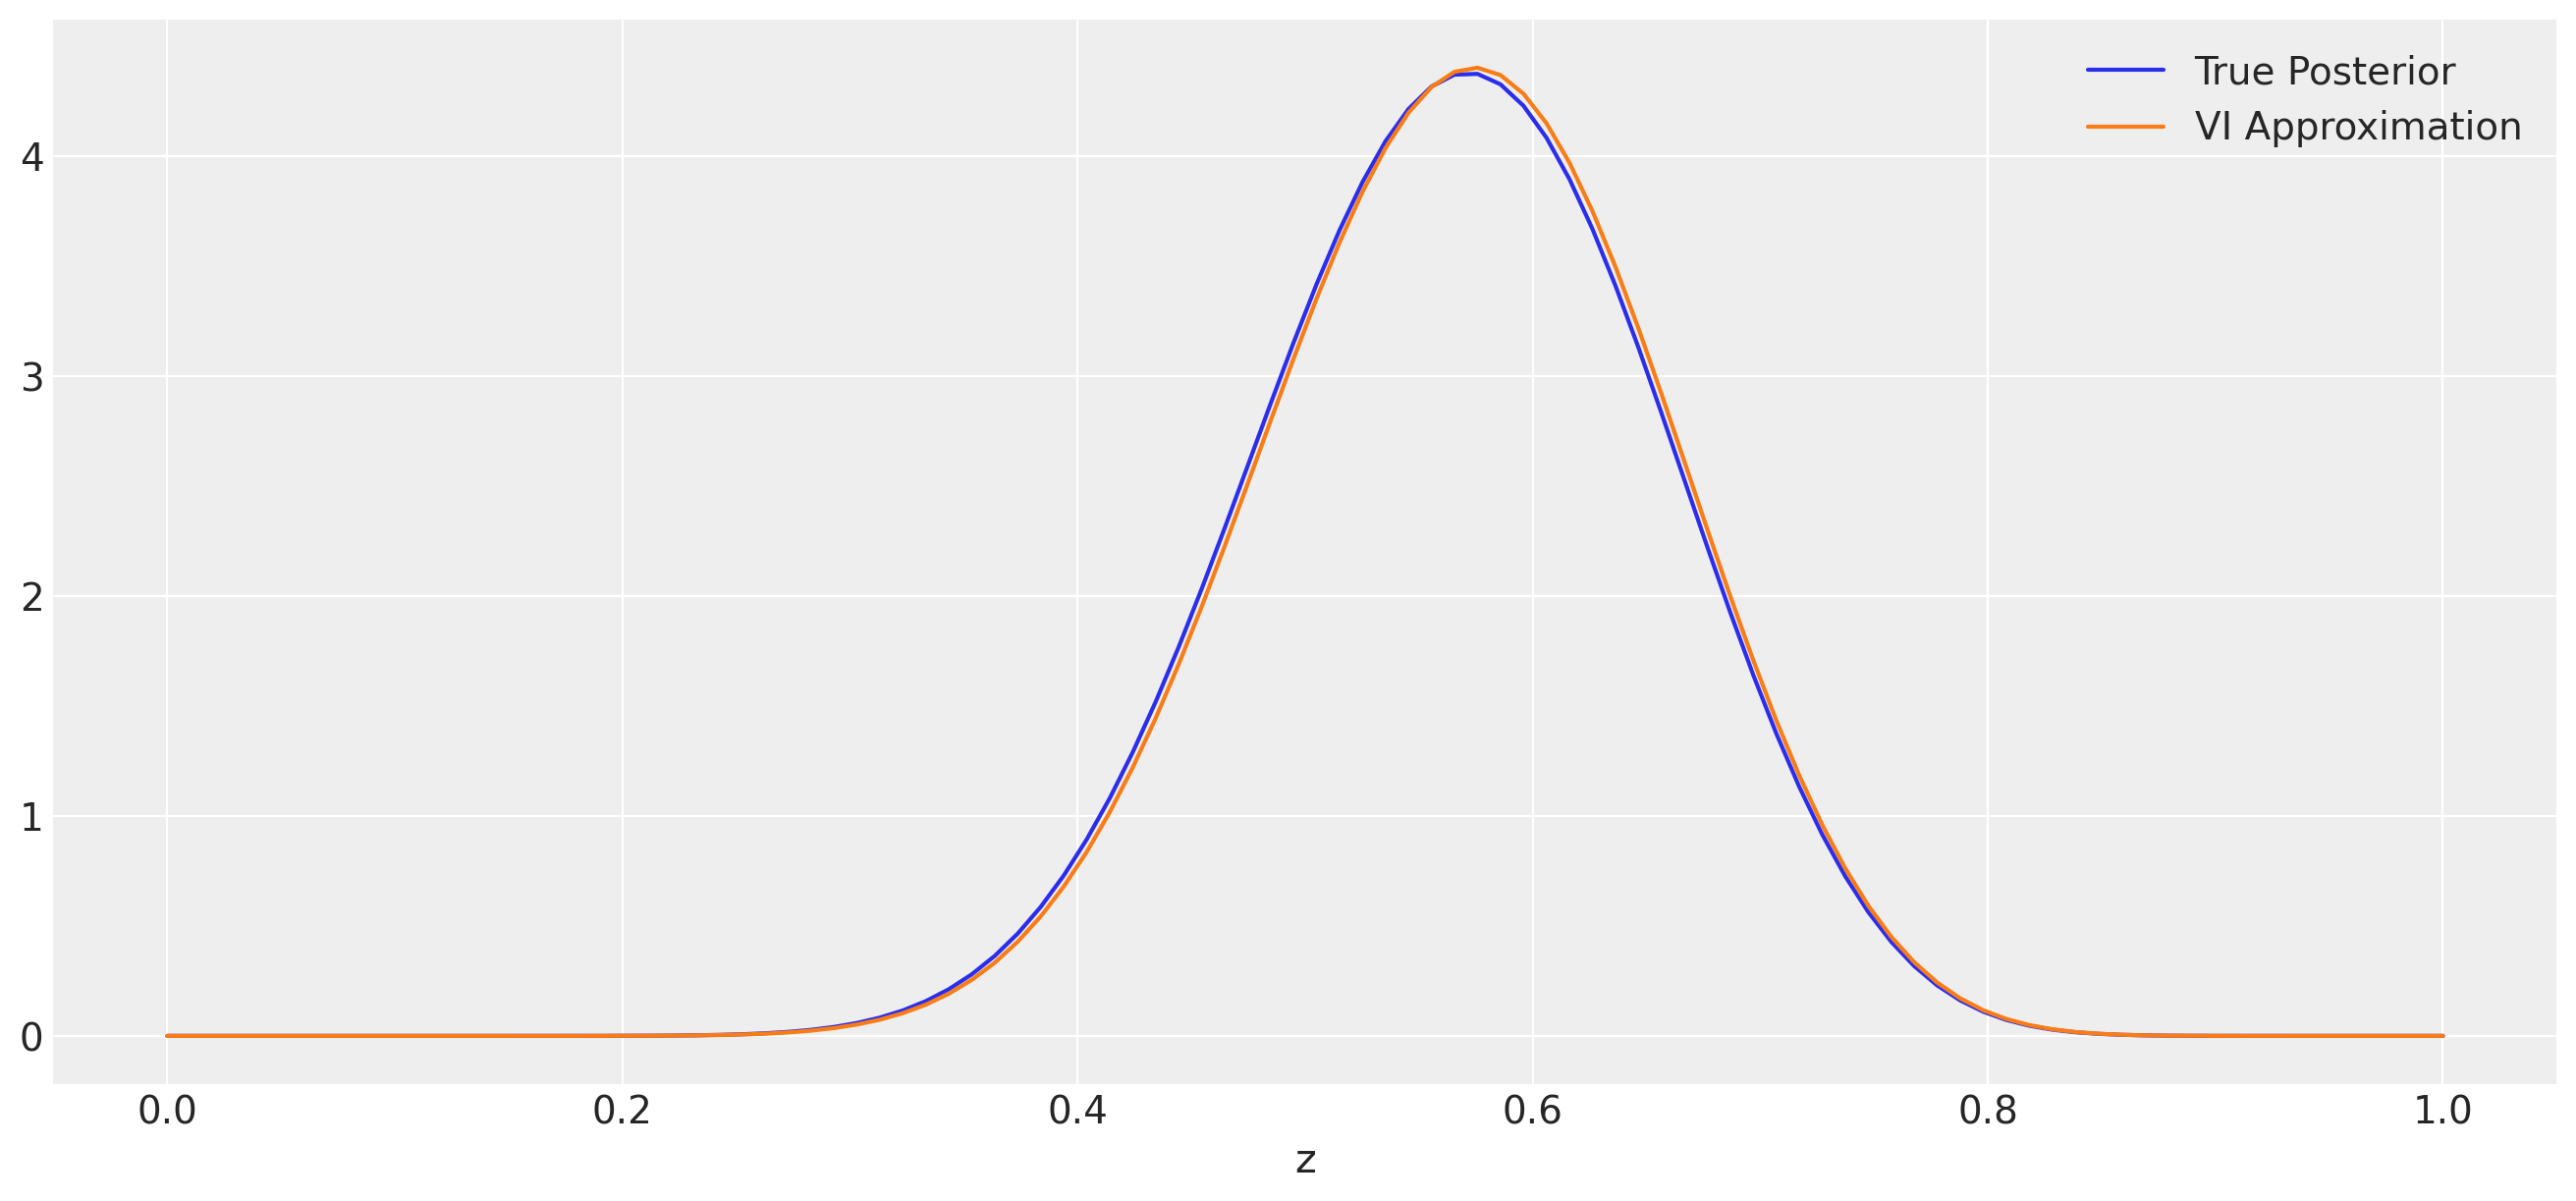

In [29]:
variational_posterior = [beta_dist.pdf(z_i, alpha_q, beta_q) for z_i in z_range]
# change figure size
plt.figure(figsize=(13,6))
sns.lineplot(x=z_range, y=posterior)
sns.lineplot(x=z_range, y=variational_posterior)
plt.xlabel('z')
plt.legend(labels=['True Posterior', 'VI Approximation'])
plt.show()

## True Posterior vs. MCMC vs. Variational Inference

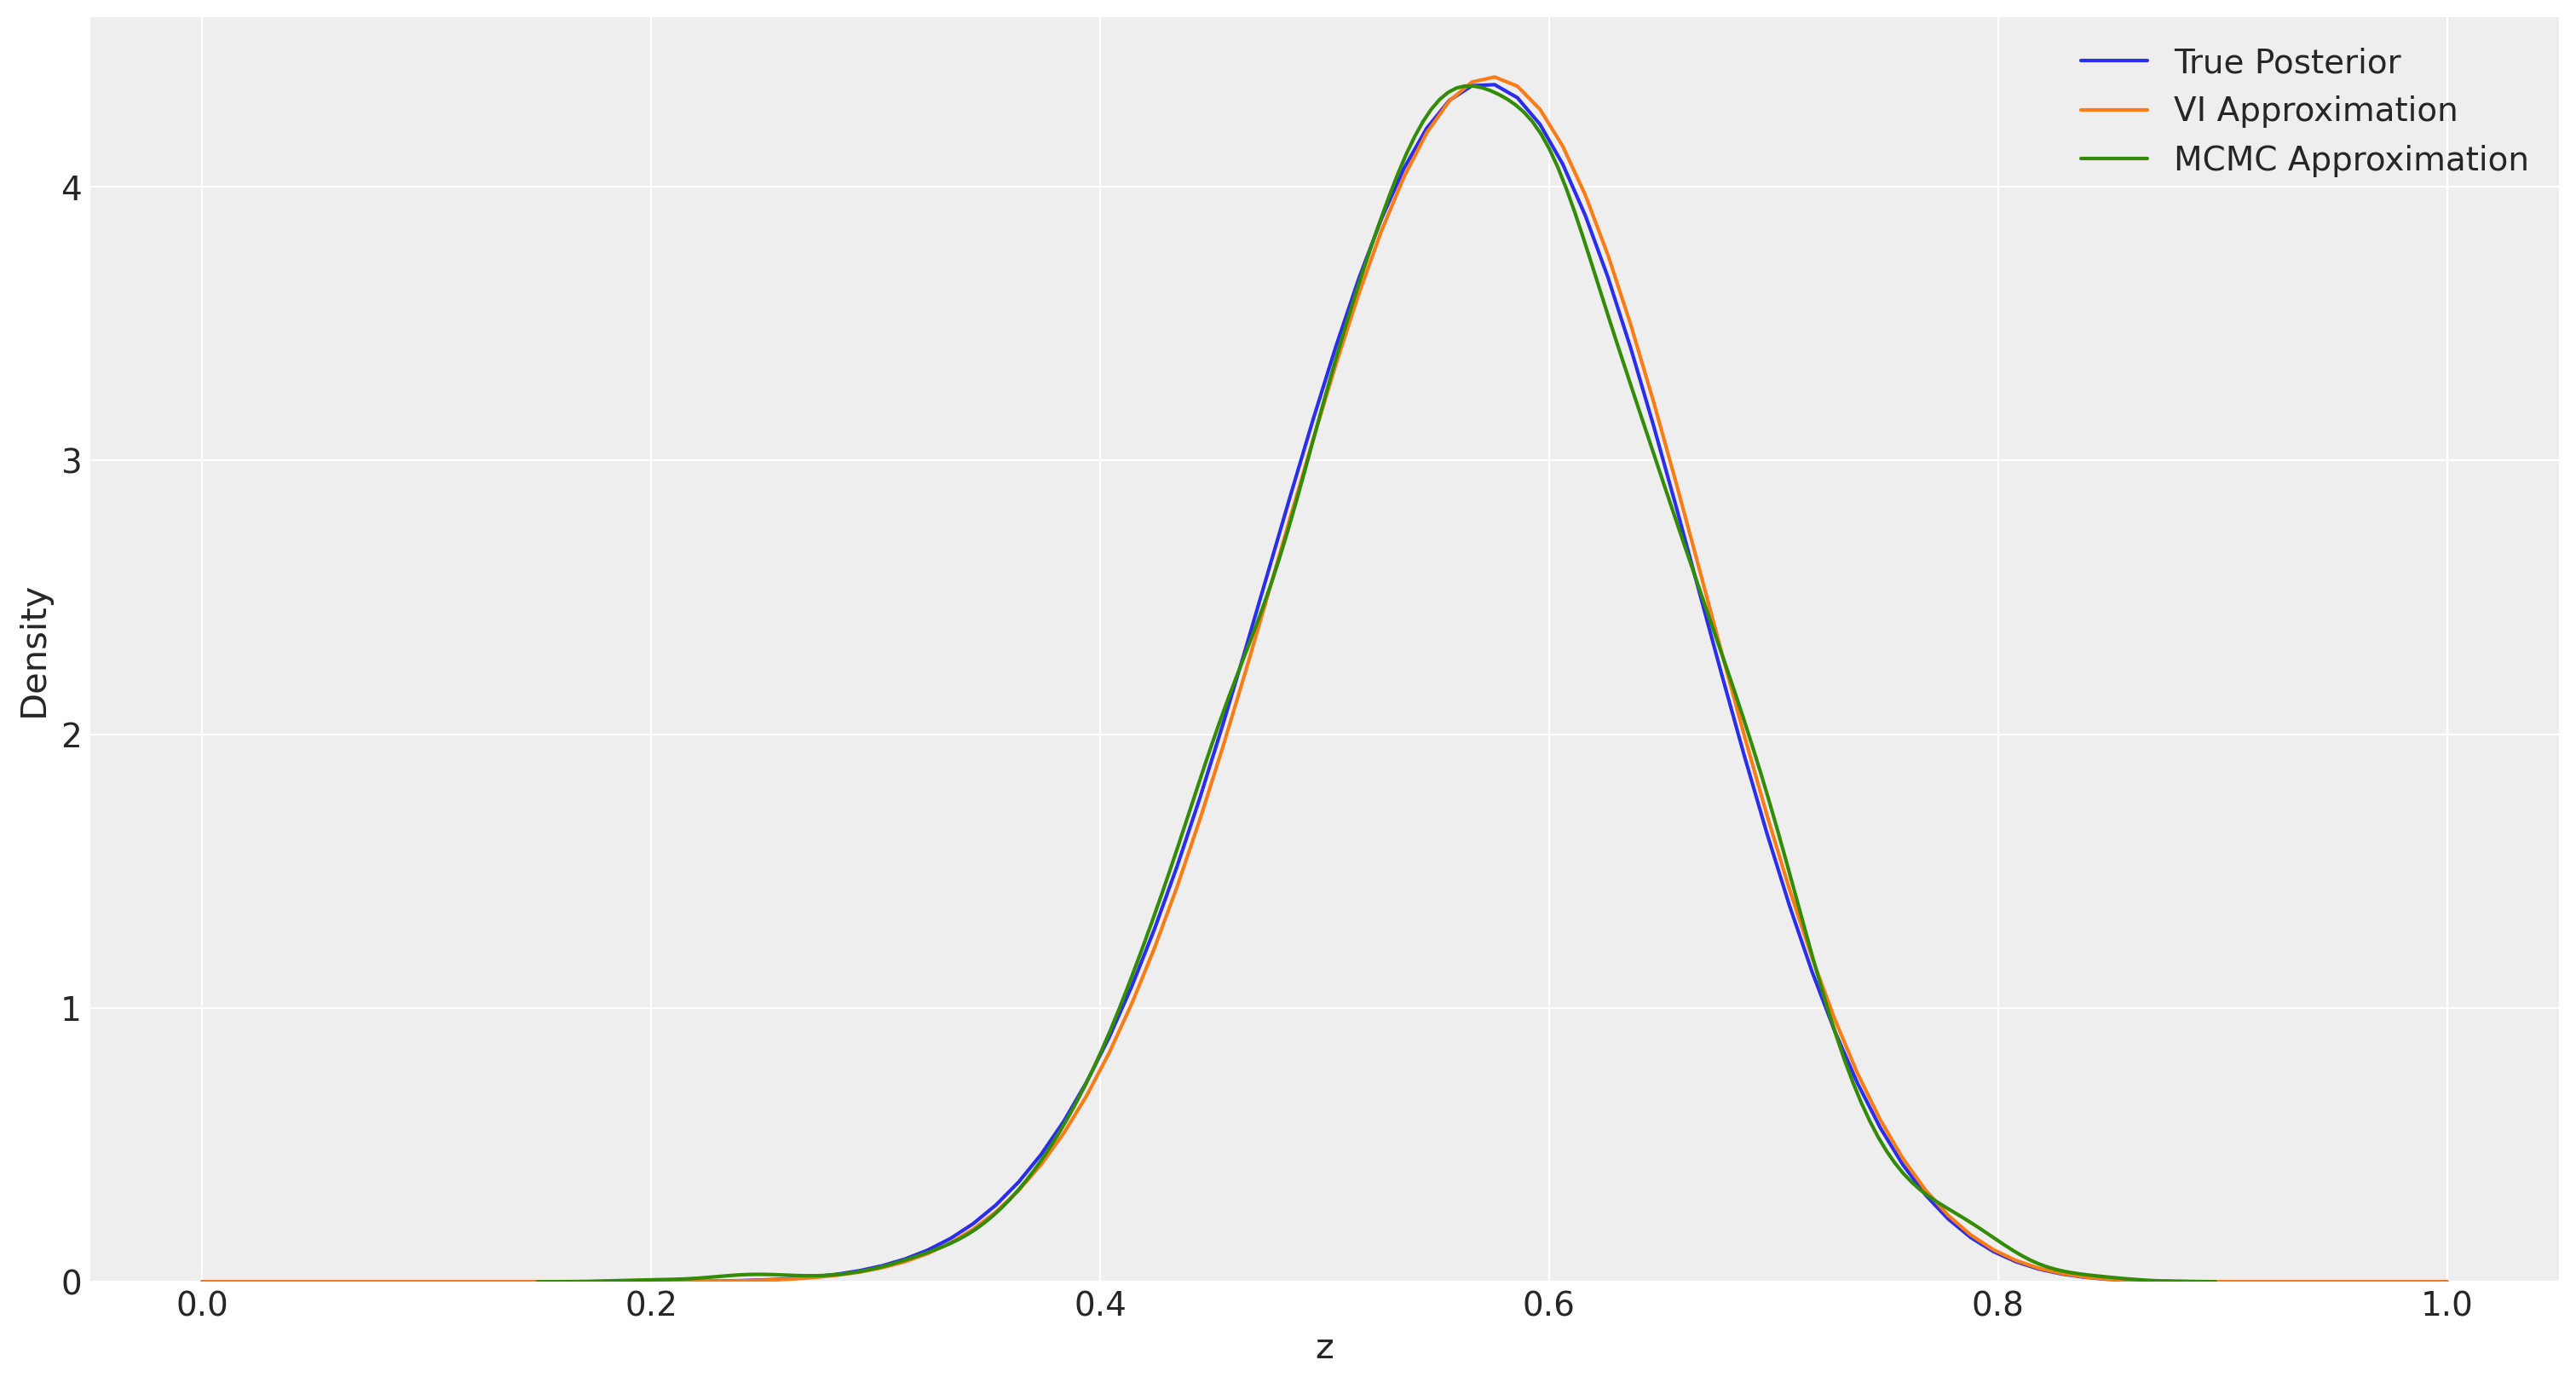

In [28]:
variational_posterior = [beta_dist.pdf(z_i, alpha_q, beta_q) for z_i in z_range]
# change figure size
plt.figure(figsize=(13,6))
sns.lineplot(x=z_range, y=posterior)
sns.lineplot(x=z_range, y=variational_posterior)
sns.kdeplot(mcmc_posterior)
plt.xlabel('z')
plt.legend(labels=['True Posterior', 'VI Approximation', 'MCMC Approximation'])
plt.show()